# Image processing phase visualized examples

## Region selection - Visualized example

In [3]:
def region_selection(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have 
		identified edges in the frame
	"""
	# create an array of the same size as of the input image 
	mask = np.zeros_like(image) 
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.0, rows * 1]
	top_left	 = [cols * 0.4, rows * 0.49]
	bottom_right = [cols * 1, rows * 1]
	top_right = [cols * 0.6, rows * 0.49]
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image

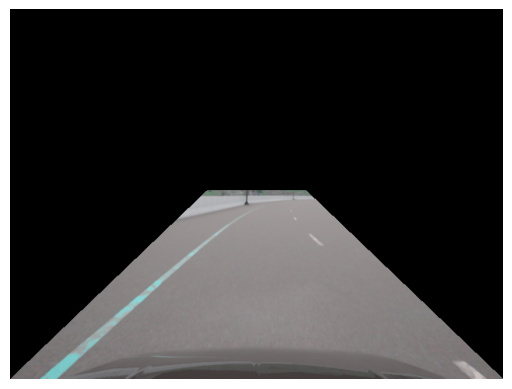

In [46]:
image = cv2.imread(r"G:\carla_data_T4_original\CCW2\137.png")
#image = cv2.imread(r"G:\carla_data_original\LT1\0.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 5
# Applying gaussian blur to remove noise from the frames
blur = cv2.GaussianBlur(image_gray, (kernel_size, kernel_size), 0)
low_t = 50
# second threshold for the hysteresis procedure 
high_t = 125
# applying canny edge detection and save edges in a variable
edges = cv2.Canny(blur, low_t, high_t)
processed_image = region_selection(image)
#processed_image = region_selection(edges)

# Assuming 'image' is your NumPy array
plt.imshow(processed_image)  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide the axis for better visualization
plt.show()